In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.io import read_image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import timm
import kornia
import numpy as np
from tqdm import tqdm
import os
import json

/home/arkplus/anaconda3/envs/hrnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# imagenet 평균, 표준편차
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# SIGMA
SIGMA = 1.5

In [3]:
# 데이터셋
class GaugeDataset(Dataset):
    def __init__(self, root_dir, ann_file, input_size=(256, 256), is_train=True):
        self.root_dir = root_dir
        with open(ann_file, "r") as f:
            self.coco = json.load(f)
        self.image_map = {img["id"]: img for img in self.coco["images"]}
        self.annotaions = self.coco["annotations"]
        self.input_size = input_size
        self.is_train = is_train

        # 정규화
        self.normalize = T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

        # 증강
        self.augment = T.Compose([
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        ]) if is_train else nn.Identity()
        

    def __len__(self):
        return len(self.annotaions)

    def __getitem__(self, index):
        annotaion = self.annotaions[index]
        image_info = self.image_map[annotaion["image_id"]]
        image_path = os.path.join(self.root_dir, image_info["file_name"])

        # Tensor C H W, 리사이즈, 0~255
        image = read_image(image_path)
        image = F.resize(image, self.input_size)
        image = image.float() / 255.0

        # 증강
        image = self.augment(image)
        # 정규화
        image = self.normalize(image)
        
        # 좌표 스케일링
        # 원본 이미지 크기 정보 가져오기
        w = image_info['width']
        h = image_info['height']

        scale_x = self.input_size[1] / w
        scale_y = self.input_size[0] / h

        keypoints = torch.tensor(annotaion["keypoints"]).view(-1, 3).float()
        keypoints[:, 0] *= scale_x
        keypoints[:, 1] *= scale_y

        return image, keypoints[:, :2]


In [4]:
# 히트맵
def generate_heatmap(keypoints, map_size, sigma=SIGMA):
    """
    [학습용] 좌표 -> 히트맵
    """
    B, N, _ = keypoints.shape
    H, W = map_size
    device = keypoints.device

    # 표준편차
    std = torch.tensor([sigma, sigma], device=device).repeat(B, N, 1)

    # Kornia 히트맵 렌더링
    heatmaps = kornia.geometry.subpix.render_gaussian2d(
        mean=keypoints,
        std=std,
        size=(H, W),
        normalized_coordinates=False # 픽셀 좌표계 사용
    )
    return heatmaps

def decode_heatmap(heatmaps):
    """
    [추론용] 히트맵 -> 좌표
    """
    # Soft Argmax
    # temperature가 높을수록 argmax에 가까워지고, 낮을수록 평균에 가까워짐
    coords = kornia.geometry.subpix.spatial_soft_argmax2d(
        input=heatmaps,
        temperature=torch.tensor(1.0, device=heatmaps.device),
        normalized_coordinates=False
    )
    return coords

In [5]:
# 모델
class GaugeHRNet(nn.Module):
    def __init__(self, num_keypoints=4, pretrained=True, stride_idx=1):
        super(GaugeHRNet, self).__init__()
        self.backbone = timm.create_model(
            "hrnet_w32",
            pretrained=pretrained,
            features_only=True
        )
        self.stride_idx = stride_idx
        # Stride 4 (64x64) 특징맵 채널 수 가져오기
        in_channels = self.backbone.feature_info.channels()[self.stride_idx]

        self.final_layer = nn.Conv2d(in_channels, num_keypoints, kernel_size=1)

    def forward(self, x):
        # 특징맵 리스트 추출
        x = self.backbone(x)[self.stride_idx]
        # Stride 4 (64x64)
        x = self.final_layer(x)
        return x

In [6]:
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    
    # 랜덤하게 샘플 선택
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(20, 4 * num_samples))
    
    inv_mean = torch.tensor([-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)]).view(3, 1, 1)
    inv_std = torch.tensor([1/s for s in IMAGENET_STD]).view(3, 1, 1)

    for i, idx in enumerate(indices):
        image, gt_keypoints = dataset[idx]
        
        # 모델 추론
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output_heatmap = model(input_tensor)
            pred_keypoints = decode_heatmap(output_heatmap).squeeze(0).cpu()
            
            # Stride 4 복원 (64x64 -> 256x256)
            pred_keypoints *= 4.0

        # 시각화를 위한 이미지 역정규화
        img_vis = image * inv_std + inv_mean
        img_vis = img_vis.permute(1, 2, 0).numpy()
        img_vis = np.clip(img_vis, 0, 1)

        # 출력
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_vis)
        
        # 정답 (Ground Truth): 초록색
        gt_np = gt_keypoints.numpy()
        plt.scatter(gt_np[:, 0], gt_np[:, 1], c="lime", edgecolors="black", s=60, label="GT", marker="o")
        
        # 예측 (Prediction): 빨간색
        pred_np = pred_keypoints.numpy()
        plt.scatter(pred_np[:, 0], pred_np[:, 1], c="red", s=40, label="Pred", marker="x")
        
        plt.title(f"Sample {idx}")
        plt.legend()
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
# 설정
IMG_DIR = "dataset/images"
TRAIN_ANN = "dataset/annotations/train.json"
VAL_ANN = "dataset/annotations/val.json"
NUM_KEYPOINTS = 4
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 100

In [8]:
checkpoint = "models/hrnet/0.552532_hrnet.pth"
state_dict = torch.load(checkpoint, map_location=DEVICE)
model = GaugeHRNet(num_keypoints=NUM_KEYPOINTS).to(DEVICE)
model.load_state_dict(state_dict)
val_dataset = GaugeDataset(IMG_DIR, VAL_ANN, is_train=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Unexpected keys (downsamp_modules.0.1.num_batches_tracked, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.2.1.num_batches_tracked, final_layer.1.num_batches_tracked, downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


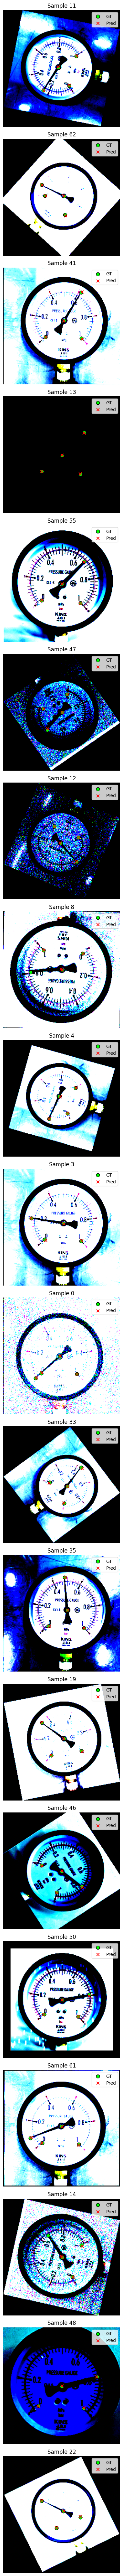

In [9]:
visualize_predictions(model, val_dataset, DEVICE, num_samples=20)